## Оценка эффективности системы рекомендаций онлайн-магазина здорового питания

**Задача**

Проанализировать собранные в ходе эксперимента данные и определить, станет ли лучше от использования нового алгоритма рекомендаций.

Примем H0 - гипотеза: выборки по контрольной и экспериментальной группам не имеют статистически значимых различий.
H1 гипотеза: выборки по контрольной и экспериментальной группам имеют статистически значимые различия.

In [1]:
import pandas as pd
import seaborn as sns
import random
from math import floor
from scipy.stats import ttest_ind

## Предварительное исследование данных

In [2]:
user=pd.read_csv('/content/drive/MyDrive/healthy_food_shop/user.csv')
user_ab_group=pd.read_csv('/content/drive/MyDrive/healthy_food_shop/user_ab_group.csv')
good=pd.read_csv('/content/drive/MyDrive/healthy_food_shop/good.csv')
user_purchase=pd.read_csv('/content/drive/MyDrive/healthy_food_shop/user_purchase.csv')
purchase_good=pd.read_csv('/content/drive/MyDrive/healthy_food_shop/purchase_good.csv')

In [3]:
user.head()

,user_id,gender,age,region
0,1,Ж,23,Краснодарский край
1,2,Ж,43,Краснодарский край
2,3,М,36,Краснодарский край
3,4,Ж,39,Краснодарский край
4,5,М,43,Иркутская область


In [4]:
user_ab_group.head()

,user_id,group
0,5034,treatment
1,4725,treatment
2,911,treatment
3,13267,control
4,5636,control


In [5]:
user_ab_group['group'].value_counts()

,count
group,
treatment,5990
control,5925


In [6]:
good.head()

,id,good_name,price_per_unit
0,1,Органический авокадо,336
1,2,Льняные семена,796
2,3,Кокосовое масло Extra Virgin,558
3,4,Гречка цельнозерновая,484
4,5,Лосось дикого копчения,480


In [7]:
user_purchase.head()

,id,user_id,date_time
0,1,5784,2023-09-20 00:01:07
1,2,4468,2023-09-20 00:04:18
2,3,3827,2023-09-20 00:04:35
3,4,3272,2023-09-20 00:06:32
4,5,9461,2023-09-20 00:08:24


In [8]:
purchase_good.head()

,purchase_id,good_id,amount,was_in_recommended_goods
0,15495,34,2,False
1,42640,48,1,False
2,42640,36,1,False
3,42640,12,2,True
4,42640,35,1,True


In [9]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  15000 non-null  int64 
 1   gender   15000 non-null  object
 2   age      15000 non-null  int64 
 3   region   15000 non-null  object
dtypes: int64(2), object(2)
memory usage: 468.9+ KB


In [10]:
user_ab_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11915 entries, 0 to 11914
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  11915 non-null  int64 
 1   group    11915 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.3+ KB


In [11]:
user_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74951 entries, 0 to 74950
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74951 non-null  int64 
 1   user_id    74951 non-null  int64 
 2   date_time  74951 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.7+ MB


In [12]:
purchase_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352057 entries, 0 to 352056
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   purchase_id               352057 non-null  int64
 1   good_id                   352057 non-null  int64
 2   amount                    352057 non-null  int64
 3   was_in_recommended_goods  352057 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 8.4 MB


In [13]:
user_purchase['date_time'].dtype

dtype('O')

In [14]:
user_purchase['date_time'] = pd.to_datetime(user_purchase['date_time'], format='%Y-%m-%d %H:%M:%S')

In [15]:
user_purchase['date_time'].dtype

dtype('<M8[ns]')

Может ли иметь место Sample Ratio Mismatch (SRM)?
Проверим с помощью моделирования данных. Смоделируем 10 000 случайных разбиений на класс 0 и 1, посмотрим распределение.

In [16]:
diffs = []

for i in range(10_000):
    arr = [random.randint(0, 1) for i in range(len(user_ab_group))]
    diff = sum(arr) - (len(arr) - sum(arr))
    diffs.append(diff)

In [17]:
diffs_s = pd.Series(diffs)

<Axes: ylabel='Count'>

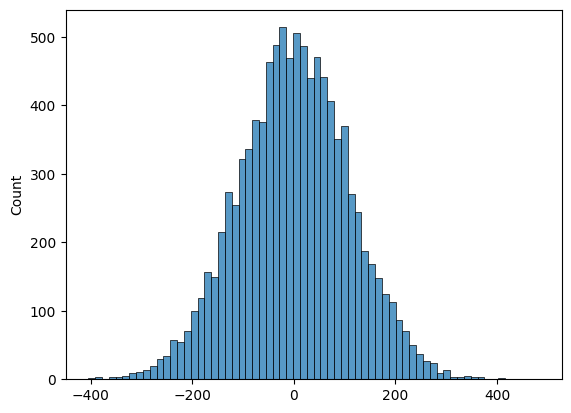

In [18]:
sns.histplot(diffs_s)

In [19]:
our_diff = user_ab_group[user_ab_group['group'] == 'treatment'].count()-user_ab_group[user_ab_group['group'] == 'control'].count()

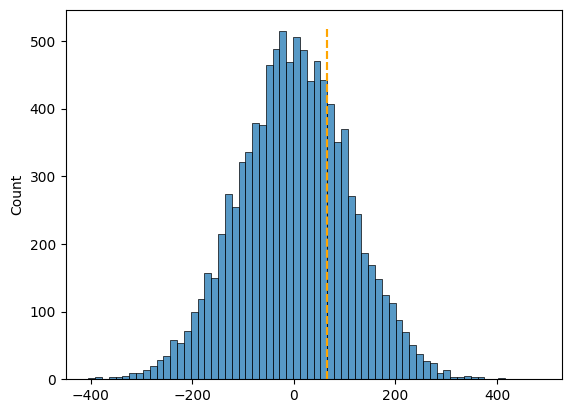

In [20]:
ax = sns.histplot(diffs)
ax.vlines(our_diff, 0, 520, linestyles='dashed', color='orange')

In [21]:
alpha = 0.05
half_alpha = floor(len(diffs_s) * alpha / 2)
diffs_cut = sorted(diffs_s)[half_alpha:-half_alpha]

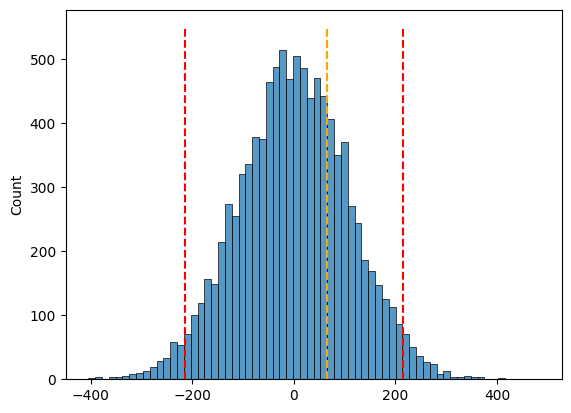

In [22]:
ax = sns.histplot(diffs)

ax.vlines([our_diff], 0, 550, linestyles='dashed', color='orange')
ax.vlines([diffs_cut[0], diffs_cut[-1]], 0, 550, linestyles='dashed', color='red')

## Подготовка данных и проведение t-теста

In [23]:
user_purchase_exp = user_purchase[(user_purchase['date_time']>='2023-10-01') & (user_purchase['date_time']<='2023-10-14')]

In [24]:
purchase_good_exp = purchase_good.merge(user_purchase_exp, left_on='purchase_id', right_on='id')
purchase_good_exp

,purchase_id,good_id,amount,was_in_recommended_goods,id,user_id,date_time
0,15495,34,2,False,15495,1,2023-10-04 10:11:52
1,20107,6,1,True,20107,2,2023-10-08 19:23:44
2,20107,17,1,False,20107,2,2023-10-08 19:23:44
3,20107,36,1,True,20107,2,2023-10-08 19:23:44
4,20107,10,2,True,20107,2,2023-10-08 19:23:44
...,...,...,...,...,...,...,...
78400,21577,66,1,True,21577,15000,2023-10-10 04:14:11
78401,21577,79,1,True,21577,15000,2023-10-10 04:14:11
78402,21577,64,1,False,21577,15000,2023-10-10 04:14:11
78403,21577,11,1,False,21577,15000,2023-10-10 04:14:11


In [25]:
purchase_good_exp=purchase_good_exp.drop('id', axis=1)

In [26]:
purchase_good_exp

,purchase_id,good_id,amount,was_in_recommended_goods,user_id,date_time
0,15495,34,2,False,1,2023-10-04 10:11:52
1,20107,6,1,True,2,2023-10-08 19:23:44
2,20107,17,1,False,2,2023-10-08 19:23:44
3,20107,36,1,True,2,2023-10-08 19:23:44
4,20107,10,2,True,2,2023-10-08 19:23:44
...,...,...,...,...,...,...
78400,21577,66,1,True,15000,2023-10-10 04:14:11
78401,21577,79,1,True,15000,2023-10-10 04:14:11
78402,21577,64,1,False,15000,2023-10-10 04:14:11
78403,21577,11,1,False,15000,2023-10-10 04:14:11


In [27]:
purchase_good_exp = purchase_good_exp.merge(user_ab_group, left_on='user_id', right_on='user_id')
purchase_good_exp

,purchase_id,good_id,amount,was_in_recommended_goods,user_id,date_time,group
0,15495,34,2,False,1,2023-10-04 10:11:52,control
1,20107,6,1,True,2,2023-10-08 19:23:44,treatment
2,20107,17,1,False,2,2023-10-08 19:23:44,treatment
3,20107,36,1,True,2,2023-10-08 19:23:44,treatment
4,20107,10,2,True,2,2023-10-08 19:23:44,treatment
...,...,...,...,...,...,...,...
65774,21577,66,1,True,15000,2023-10-10 04:14:11,treatment
65775,21577,79,1,True,15000,2023-10-10 04:14:11,treatment
65776,21577,64,1,False,15000,2023-10-10 04:14:11,treatment
65777,21577,11,1,False,15000,2023-10-10 04:14:11,treatment


In [28]:
purchase_good_exp['group'].isnull().sum()

0

<Axes: xlabel='group', ylabel='Count'>

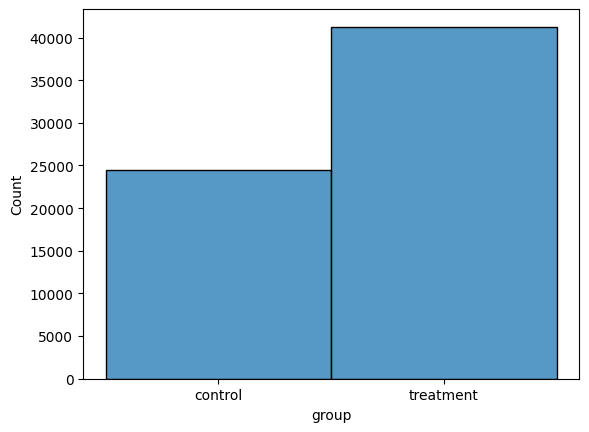

In [29]:
sns.histplot(purchase_good_exp['group'])

In [30]:
count_purchase_control = purchase_good_exp[purchase_good_exp['group'] == 'control']
count_purchase_control

,purchase_id,good_id,amount,was_in_recommended_goods,user_id,date_time,group
0,15495,34,2,False,1,2023-10-04 10:11:52,control
14,19082,53,1,False,4,2023-10-07 21:01:06,control
15,19110,26,1,True,9,2023-10-07 21:32:20,control
38,17172,25,2,False,15,2023-10-06 02:19:20,control
39,17172,11,1,False,15,2023-10-06 02:19:20,control
...,...,...,...,...,...,...,...
65727,15752,51,1,False,14983,2023-10-04 16:32:08,control
65728,15752,4,1,True,14983,2023-10-04 16:32:08,control
65729,13546,19,1,False,14985,2023-10-02 13:42:06,control
65730,22368,76,1,False,14985,2023-10-10 21:42:06,control


In [31]:
purchase_good_exp = purchase_good_exp.merge(good, left_on='good_id', right_on='id')
purchase_good_exp

,purchase_id,good_id,amount,was_in_recommended_goods,user_id,date_time,group,id,good_name,price_per_unit
0,15495,34,2,False,1,2023-10-04 10:11:52,control,34,Кишмиш-жмых,464
1,20107,6,1,True,2,2023-10-08 19:23:44,treatment,6,Греческий йогурт с низким содержанием жира,426
2,20107,17,1,False,2,2023-10-08 19:23:44,treatment,17,Бобовые чипсы,539
3,20107,36,1,True,2,2023-10-08 19:23:44,treatment,36,Льняные хлопья,404
4,20107,10,2,True,2,2023-10-08 19:23:44,treatment,10,Мед манука,497
...,...,...,...,...,...,...,...,...,...,...
65774,21577,66,1,True,15000,2023-10-10 04:14:11,treatment,66,Грецкие орехи,429
65775,21577,79,1,True,15000,2023-10-10 04:14:11,treatment,79,Кокосовые хлопья,379
65776,21577,64,1,False,15000,2023-10-10 04:14:11,treatment,64,Бобы мунг,546
65777,21577,11,1,False,15000,2023-10-10 04:14:11,treatment,11,Кедровые орехи,470


In [32]:
purchase_good_exp['purchase_sum'] = purchase_good_exp['amount'] * purchase_good_exp['price_per_unit']

In [33]:
purchase_good_exp=purchase_good_exp.drop(columns=['good_name', 'price_per_unit', 'id'])
purchase_good_exp

,purchase_id,good_id,amount,was_in_recommended_goods,user_id,date_time,group,purchase_sum
0,15495,34,2,False,1,2023-10-04 10:11:52,control,928
1,20107,6,1,True,2,2023-10-08 19:23:44,treatment,426
2,20107,17,1,False,2,2023-10-08 19:23:44,treatment,539
3,20107,36,1,True,2,2023-10-08 19:23:44,treatment,404
4,20107,10,2,True,2,2023-10-08 19:23:44,treatment,994
...,...,...,...,...,...,...,...,...
65774,21577,66,1,True,15000,2023-10-10 04:14:11,treatment,429
65775,21577,79,1,True,15000,2023-10-10 04:14:11,treatment,379
65776,21577,64,1,False,15000,2023-10-10 04:14:11,treatment,546
65777,21577,11,1,False,15000,2023-10-10 04:14:11,treatment,470


In [34]:
pur_user_mean_con = purchase_good_exp[purchase_good_exp['group'] == 'control'].groupby('user_id', as_index = False).agg({'purchase_sum':'sum'})
pur_user_mean_con

,user_id,purchase_sum
0,1,928
1,4,447
2,9,559
3,15,5279
4,16,1290
...,...,...
4103,14979,3012
4104,14980,647
4105,14983,3126
4106,14985,991


In [35]:
pur_user_mean_con_l=list(pur_user_mean_con['purchase_sum'])
len(pur_user_mean_con)

4108

In [36]:
pur_user_mean_treat = purchase_good_exp[purchase_good_exp['group'] == 'treatment'].groupby('user_id', as_index=False).agg({'purchase_sum':'sum'})
pur_user_mean_treat

,user_id,purchase_sum
0,2,7190
1,10,3587
2,12,640
3,13,7921
4,21,7696
...,...,...
4109,14988,1530
4110,14994,2586
4111,14996,6996
4112,14998,6498


In [37]:
pur_user_mean_treat_l = list(pur_user_mean_treat['purchase_sum'])

In [38]:
pur_user_mean_con_l = pur_user_mean_con_l + [0]*(len(user_ab_group[user_ab_group['group'] == 'control']) - len(pur_user_mean_con_l))
len(pur_user_mean_con_l)

5925

In [39]:
pur_user_mean_treat_l = pur_user_mean_treat_l + [0]*(len(user_ab_group[user_ab_group['group'] == 'treatment']) - len(pur_user_mean_treat_l))
len(pur_user_mean_treat_l)

5990

<Axes: ylabel='Count'>

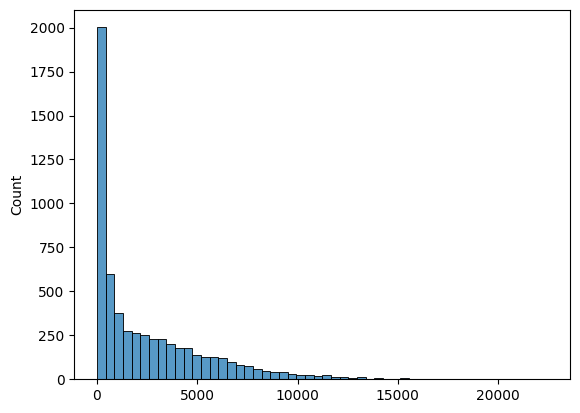

In [40]:
sns.histplot(list(pur_user_mean_con_l))

<Axes: ylabel='Count'>

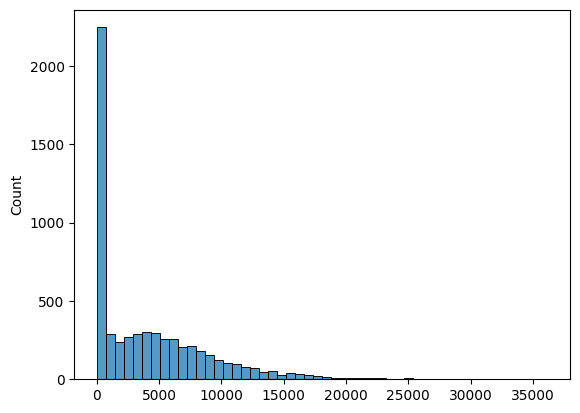

In [41]:
sns.histplot(list(pur_user_mean_treat_l))

<Axes: ylabel='Count'>

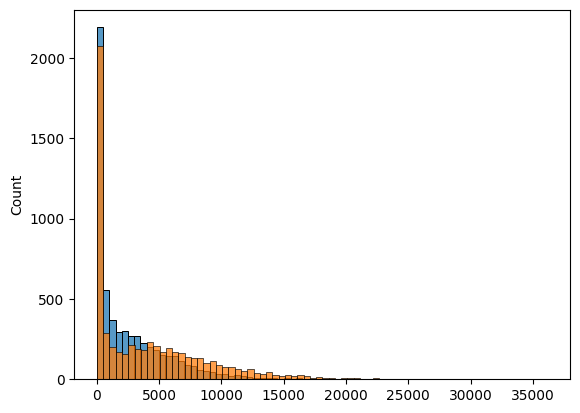

In [42]:
sns.histplot(list(pur_user_mean_con_l), binwidth=500)
sns.histplot(list(pur_user_mean_treat_l), binwidth=500)

In [43]:
ttest_ind(pur_user_mean_con_l, pur_user_mean_treat_l, equal_var = False)

TtestResult(statistic=-22.822459080716186, pvalue=1.7078036878756089e-112, df=10237.532866168285)

Вывод по результатам t-теста:
p-value < 0.05 следовательно гипотезу H0 можно отвергнуть, гипотезу H1 принимаем, выборки (контрольная и экспериментальная группы) имеют значимые статистические отличия.

## Интерпретация результата

1. Стало ли больше количество покупок?

<Axes: xlabel='date_time', ylabel='Count'>

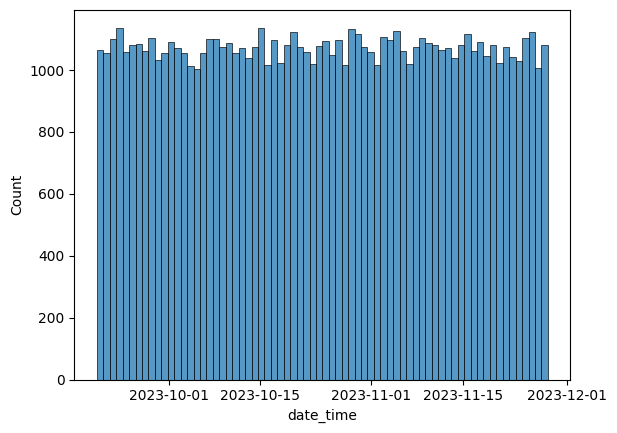

In [44]:
sns.histplot(user_purchase['date_time'].dt.floor('D'), bins=70)

2. Стала ли больше суммарная выручка?

In [45]:
vir_control = purchase_good_exp['purchase_sum'][purchase_good_exp['group'] == 'control'].sum()
vir_control

14593387

In [46]:
vir_treatment = purchase_good_exp['purchase_sum'][purchase_good_exp['group'] == 'treatment'].sum()
vir_treatment

24517286

3. Стали ли покупать больше товаров из рекомендаций?

In [47]:
purchase_good_exp['good_id'][(purchase_good_exp['group'] == 'control') & (purchase_good_exp['was_in_recommended_goods'] == True)].count()/purchase_good_exp['good_id'][purchase_good_exp['group'] == 'control'].count()

0.29836801305589555

In [48]:
purchase_good_exp['good_id'][(purchase_good_exp['group'] == 'treatment') & (purchase_good_exp['was_in_recommended_goods'] == True)].count()/purchase_good_exp['good_id'][purchase_good_exp['group'] == 'treatment'].count()

0.44835106254089024

Результаты можно интерпретировать следующим образом:
1. По графику распределения количества покупок нет никакого увеличения количества покупок в период проведения эксперимента.
2. Суммарная выручка от покупок в экспериментальной группе значительно выше, чем в контрольной группе.
3. Соотношение рекомендованные товары / купленные товары в экспериментальной группе значительно выше, чем в контрольной группе.

Выводы:
1. Внедрённая система рекомендаций влияет на поведение пользователей.
2. Пользователи стали больше покупать товаров из рекомендованных, выручка увеличилась.